In [62]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)
import seaborn as sns
from keras.callbacks import ModelCheckpoint

# define the accuracy function

In [63]:
def compute_accuracy(y, y_hat):
    x = np.array(y == y_hat).astype(int)
    return np.sum(x)/len(y)

# define the reweighted accuracy function

In [64]:
def reweighted_accuracy(y1_hat,y , A):
    n_0 = np.count_nonzero(A == 0)
    n_1 = np.count_nonzero(A)
    a_0 = np.where(A == 0)[0]
    a_1 = np.where(A==1)[0]
    
    y_0 = np.count_nonzero(y1_hat[a_0] == y[a_0])/n_0
    y_1 = np.count_nonzero(y1_hat[a_1] == y[a_1])/n_1
    r = (y_0 + y_1)/2
    return r

# define the delta_DP function

In [65]:
def compute_delta_DP(y_hat, a):
    n_a_0, n_a_1 = np.count_nonzero(a==0), np.count_nonzero(a)
    y_hat_0 = y_hat[np.where(a == 0)]
    y_hat_1 = y_hat[np.where(a == 1)]
    delta_dp = np.abs(np.sum(y_hat_0)/n_a_0 - np.sum(y_hat_1)/n_a_1)
    return delta_dp

#  10 most corelated attributes with y and 10 most corelated attributes with a

### load and visualize data

In [66]:
npz = np.load('adult/adult_train.npz')

In [67]:
df = pd.DataFrame(list(npz['x']))
df.head()

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,0.050889,0.247351,0.264519,0.220356,0.135684,0.061884,0.019318,0.697030,0.078038,0.034274,...,0.001044,0.000369,0.000553,0.000491,0.003255,0.000584,0.000952,0.000614,0.000031,0.017905
std,0.219775,0.431479,0.441083,0.414493,0.342458,0.240948,0.137641,0.459549,0.268236,0.181935,...,0.032298,0.019194,0.023506,0.022162,0.056964,0.024149,0.030841,0.024776,0.005542,0.132608
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [69]:


data = pd.read_csv('adult/adult_headers.txt', header = None)
data.columns = ['header']
headers = []
for header in data['header']:
    headers.append(header)

In [70]:
len(headers)

114

In [71]:
df.columns = headers[0:len(headers)-1]
df.head()

,age_u20,age_u30,age_u40,age_u50,age_u60,age_u70,age_u80,workclass_Private,workclass_Self-emp-not-inc,workclass_Self-emp-inc,...,country_Nicaragua,country_Scotland,country_Thailand,country_Yugoslavia,country_El-Salvador,country_Trinadad&Tobago,country_Peru,country_Hong,country_Holand-Netherlands,country_?
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
df_y =  pd.DataFrame(list(npz['y']))
y =headers[len(headers)-1]
df_y.columns = [y]
df_y.head()

,income
0,0.0
1,0.0
2,1.0
3,1.0
4,0.0


In [73]:
adult_dataset = pd.concat([df, df_y], axis=1)

In [74]:
adult_dataset.head()

,age_u20,age_u30,age_u40,age_u50,age_u60,age_u70,age_u80,workclass_Private,workclass_Self-emp-not-inc,workclass_Self-emp-inc,...,country_Scotland,country_Thailand,country_Yugoslavia,country_El-Salvador,country_Trinadad&Tobago,country_Peru,country_Hong,country_Holand-Netherlands,country_?,income
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### top 10 correlated with y

In [75]:
incom = pd.DataFrame(np.abs(adult_dataset.corr()['income']))

In [76]:
corr_income = incom.sort_values(by='income',  ascending=False)
top_10 = corr_income[1:11] #the first row is y itself
top_10

,income
marital-status_Married-civ-spouse,0.444696
relationship_Husband,0.401035
education_num,0.335154
marital-status_Never-married,0.318440
age_u30,0.238133
hours-per-week,0.229689
relationship_Own-child,0.228532
capital-gain,0.223329
sex_Male,0.215980
sex_Female,0.215980


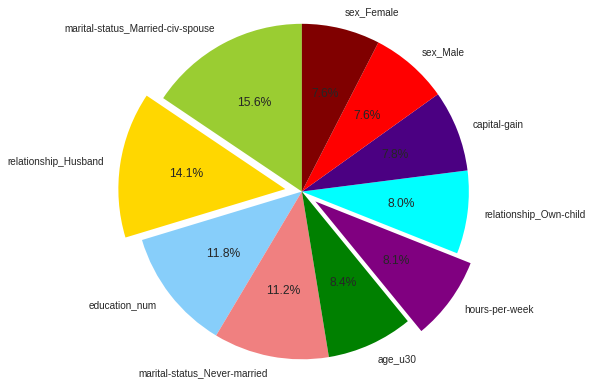

In [77]:
labels = [att for att in top_10['income'].index]

#labels = ['Cookies', 'Jellybean', 'Milkshake', 'Cheesecake']
sizes = [top_10['income'][i]*100/10 for i in range(10)]
#colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
explode = (0, 0.1, 0, 0, 0, 0.1, 0, 0, 0, 0)  

#fig1, ax1 = plt.subplots()
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'green', 'purple', 'cyan', 'indigo', 'red', 'maroon']
#fig1, ax1 = plt.subplots()
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.tight_layout()
plt.savefig('corr10_y.png', dpi= 500 )
plt.show()

### top 10 correlated with A

In [78]:
df_a =  pd.DataFrame(list(npz['a']))
df_a.columns = ['sexe']
df_a.head()

,sexe
0,0.0
1,0.0
2,1.0
3,1.0
4,0.0


In [79]:
adult_dataset_a = pd.concat([df, df_a], axis=1)


In [80]:
a = pd.DataFrame(np.abs(adult_dataset_a.corr()['sexe']))
corr_a = a.sort_values(by='sexe',  ascending=False)
top_10_corr_a = corr_a[1:11]  #the first row is a itself
top_10_corr_a

,sexe
sex_Female,1.000000
sex_Male,1.000000
relationship_Husband,0.580135
marital-status_Married-civ-spouse,0.431805
relationship_Unmarried,0.321273
relationship_Wife,0.319311
occupation_Adm-clerical,0.263148
hours-per-week,0.229309
marital-status_Divorced,0.228621
occupation_Craft-repair,0.223128


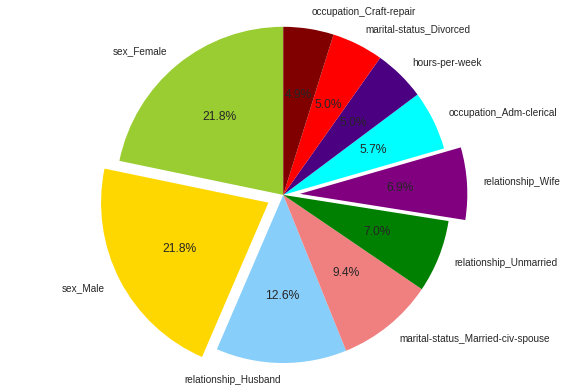

In [81]:
labels = [att for att in top_10_corr_a['sexe'].index]

#labels = ['Cookies', 'Jellybean', 'Milkshake', 'Cheesecake']
sizes = [top_10_corr_a['sexe'][i]*100/10 for i in range(10)]
#colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
explode = (0, 0.1, 0, 0, 0, 0.1, 0, 0, 0, 0)  
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'green', 'purple', 'cyan', 'indigo', 'red', 'maroon']
#fig1, ax1 = plt.subplots()
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow= False, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.tight_layout()
plt.savefig('corr10_a.png', dpi= 500 )
plt.show()

# Build a classifier

In [82]:
def build_model(train_data, train_target, val_data, val_target, batch_size=32, epochs=300, verbose=1):
    # Build neural network
    model1 = Sequential()
    model1.add(Dense(256, activation='relu', input_dim=train_data.shape[1]))
    #model.add(Dropout(0.1))
    model1.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.1))
    model1.add(Dense(1, activation='sigmoid'))

    # Compile model
    model1.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])

    # Train model
    model1.fit(train_data, train_target,
              batch_size=batch_size,
              epochs=epochs,
              verbose=verbose,
              validation_data=(val_data, val_target))
    return model1
def scaling_data(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    data = scaler.transform(data)
    return data
    
def evaluate_model(model, test_data, test_target):
    score = model.evaluate(test_data, test_target, verbose=0)
    return score[1]
def predict(model, test_data):
    y_hat = model.predict_classes(test_data)
    return y_hat

In [83]:
#get the training data

X_train = df.copy()  #contents only attributes in x
Y_train = df_y #contents only y attribut

##loading test data
npz_test = np.load('adult/adult_test.npz')
df_test = pd.DataFrame(list(npz_test['x']))
df_test.columns = headers[0:len(headers)-1]

Y_test = pd.DataFrame(list(npz_test['y']))
a_test =  pd.DataFrame(list(npz_test['a']))
a_test.columns = ['sexe']

X_train = np.array(X_train)
Y_train = np.array(Y_train)
Y_train = Y_train.flatten()

X_test = np.array(df_test)
Y_test = np.array(Y_test)
Y_test = Y_test.flatten()
X_train.shape[0]

train_ind = np.random.choice(X_train.shape[0], 3*X_train.shape[0]//4, replace=False) ## choose indexes for train and validation set


X_train, Y_train = X_train[train_ind], Y_train[train_ind]
X_val= df.drop(train_ind, axis=0)
Y_val = df_y.drop(train_ind)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
Y_val = Y_val.flatten()
# X_train = scaling_data(X_train)
# X_test = scaling_data(X_test)
# X_val = scaling_data(X_val)

In [84]:
model = build_model(X_train, Y_train, X_val, Y_val)

Train on 24420 samples, validate on 8141 samples
Epoch 1/300
24420/24420 [==============================] - 1s 45us/step - loss: 1.2151 - acc: 0.8023 - val_loss: 1.1533 - val_acc: 0.7986
Epoch 2/300
24420/24420 [==============================] - 1s 45us/step - loss: 1.1829 - acc: 0.8100 - val_loss: 1.1247 - val_acc: 0.8188
Epoch 3/300
24420/24420 [==============================] - 1s 39us/step - loss: 1.1788 - acc: 0.8137 - val_loss: 1.1247 - val_acc: 0.8191
Epoch 4/300
24420/24420 [==============================] - 1s 34us/step - loss: 1.1720 - acc: 0.8166 - val_loss: 1.1212 - val_acc: 0.8225
Epoch 5/300
24420/24420 [==============================] - 1s 34us/step - loss: 1.1701 - acc: 0.8172 - val_loss: 1.1183 - val_acc: 0.8245
Epoch 6/300
24420/24420 [==============================] - 1s 34us/step - loss: 1.1684 - acc: 0.8173 - val_loss: 1.1202 - val_acc: 0.8180
Epoch 7/300
24420/24420 [==============================] - 1s 34us/step - loss: 1.1662 - acc: 0.8201 - val_loss: 1.1195 - v

### Report classification accuracy and ∆ DP on the test set for your trained classifier.

In [85]:
print('accuracy is: ', evaluate_model(model, X_test, Y_test))

accuracy is:  0.7774706713017356


In [86]:
y_hat = predict(model, X_test)
compute_delta_DP(y_hat, a_test)

0.12024473069228425

### Remove the 10 attributes that you identified in the first part as being most highly correlated with A, and retrain. Report accuracy and ∆ DP on this retrained classifier

In [87]:
top_attributes = [att for att in top_10['income'].index]
df_without_10 = df.drop(top_attributes, axis=1)
X_train = df_without_10
X_test = df_test.drop(top_attributes, axis=1)


X_train = np.array(X_train)
X_test = np.array(X_test)


#train_ind = np.random.choice(X_train.shape[0], 3*X_train.shape[0]//4, replace=False)
X_train = X_train[train_ind]
X_val= df_without_10.drop(train_ind, axis=0)
X_val = np.array(X_val)

# X_train = scaling_data(X_train)
# X_val = scaling_data(X_val)
# X_test = scaling_data(X_test)

In [88]:
model1 = build_model(X_train, Y_train, X_val, Y_val)

Train on 24420 samples, validate on 8141 samples
Epoch 1/300
24420/24420 [==============================] - 1s 46us/step - loss: 0.7407 - acc: 0.8115 - val_loss: 0.7434 - val_acc: 0.8165
Epoch 2/300
24420/24420 [==============================] - 1s 35us/step - loss: 0.7213 - acc: 0.8221 - val_loss: 0.7344 - val_acc: 0.8194
Epoch 3/300
24420/24420 [==============================] - 1s 36us/step - loss: 0.7155 - acc: 0.8241 - val_loss: 0.7355 - val_acc: 0.8171
Epoch 4/300
24420/24420 [==============================] - 1s 37us/step - loss: 0.7096 - acc: 0.8266 - val_loss: 0.7386 - val_acc: 0.8202
Epoch 5/300
24420/24420 [==============================] - 1s 34us/step - loss: 0.7040 - acc: 0.8295 - val_loss: 0.7499 - val_acc: 0.8197
Epoch 6/300
24420/24420 [==============================] - 1s 34us/step - loss: 0.6989 - acc: 0.8327 - val_loss: 0.7494 - val_acc: 0.8188
Epoch 7/300
24420/24420 [==============================] - 1s 35us/step - loss: 0.6934 - acc: 0.8346 - val_loss: 0.7498 - v

### Report classification accuracy and ∆ DP on the test set for your trained classifier.

In [89]:
score = evaluate_model(model1, X_test, Y_test)
print('Test accuracy:', score)

Test accuracy: 0.8019163442305284


In [90]:
y_hat = predict(model1, X_test)
print('delta DP', compute_delta_DP(y_hat, a_test))

delta DP 0.12579532633986307


### Which sensitive group has higher values of Ŷ , on average?

### Let’s take a look at how the features in our data correlate with the learned predictor Ŷ . Which three features in the data are most correlated with Ŷ ?

In [91]:
y_hat_df = pd.DataFrame(y_hat)
y_hat_df.columns = ['predicted_income']

In [92]:
adult_dataset_pred_incom = pd.concat([df_test, y_hat_df], axis=1)
adult_dataset_pred_incom.corr().head()

,age_u20,age_u30,age_u40,age_u50,age_u60,age_u70,age_u80,workclass_Private,workclass_Self-emp-not-inc,workclass_Self-emp-inc,...,country_Scotland,country_Thailand,country_Yugoslavia,country_El-Salvador,country_Trinadad&Tobago,country_Peru,country_Hong,country_Holand-Netherlands,country_?,predicted_income
age_u20,1.000000,-0.133104,-0.141223,-0.124144,-0.092967,-0.061391,-0.035956,0.021240,-0.053719,-0.030268,...,-0.005530,-0.006386,0.008420,0.002178,-0.005214,0.001945,-0.005829,NaN,-0.020049,-0.112211
age_u30,-0.133104,1.000000,-0.339982,-0.298866,-0.223811,-0.147795,-0.086561,0.110328,-0.105246,-0.074662,...,-0.007217,-0.004815,-0.011740,0.013363,0.000379,0.001699,-0.002468,NaN,0.009475,-0.245038
age_u40,-0.141223,-0.339982,1.000000,-0.317095,-0.237461,-0.156809,-0.091841,0.055679,-0.008761,-0.009385,...,-0.008205,0.004199,-0.005744,0.020349,0.011800,-0.009065,0.018810,NaN,-0.002851,0.010768
age_u50,-0.124144,-0.298866,-0.317095,1.000000,-0.208744,-0.137845,-0.080734,-0.044525,0.041431,0.046419,...,-0.012417,0.002106,-0.003774,-0.012713,-0.004993,0.008484,-0.001080,NaN,0.006098,0.194016
age_u60,-0.092967,-0.223811,-0.237461,-0.208744,1.000000,-0.103228,-0.060459,-0.063406,0.043695,0.042412,...,0.013629,0.009119,0.026460,-0.015164,-0.000661,0.005756,-0.009802,NaN,-0.001455,0.142030


In [93]:
predicted_incom = pd.DataFrame(np.abs(adult_dataset_pred_incom.corr()['predicted_income']))
corr_pred_income = predicted_incom.sort_values(by='predicted_income',  ascending=False)
top_10_predicted = corr_pred_income[1:4] #the first row is y itself
top_10_predicted

,predicted_income
marital-status_Married-civ-spouse,0.389969
education_num,0.381473
relationship_Husband,0.334888


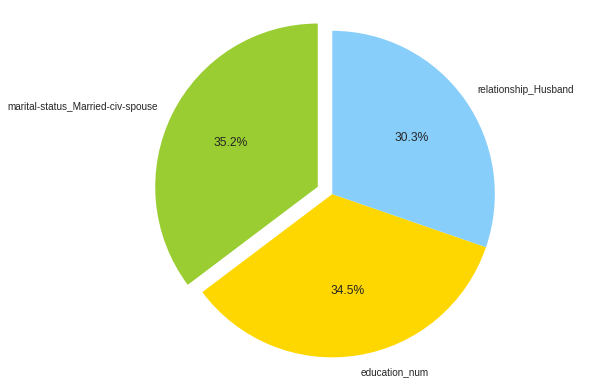

In [94]:
labels = [att for att in top_10_predicted['predicted_income'].index]

#labels = ['Cookies', 'Jellybean', 'Milkshake', 'Cheesecake']
sizes = [top_10_predicted['predicted_income'][i]*100/3 for i in range(3)]
#colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
explode = (0.1, 0, 0)  
colors = ['yellowgreen', 'gold', 'lightskyblue']
#fig1, ax1 = plt.subplots()
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.tight_layout()
plt.savefig('corr3_y.png', dpi= 500 )
plt.show()

### Which three features are most correlated with Ŷ , only looking at examples where A = 0?

In [95]:
adult_dataset_pred_incom_0 = adult_dataset_pred_incom.drop(np.where(a_test==1)[0], axis=0)
predicted_incom_0 = pd.DataFrame(np.abs(adult_dataset_pred_incom_0.corr()['predicted_income']))
corr_pred_income_0 = predicted_incom_0.sort_values(by='predicted_income',  ascending=False)
top_10_predicted_0 = corr_pred_income_0[1:4] #the first row is y itself
top_10_predicted_0

,predicted_income
relationship_Wife,0.486388
marital-status_Married-civ-spouse,0.452018
education_num,0.283427


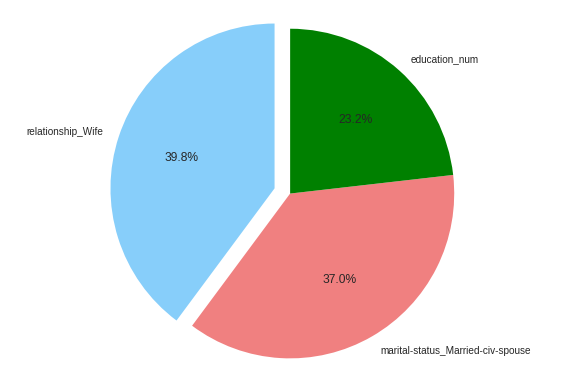

In [96]:
labels = [att for att in top_10_predicted_0['predicted_income'].index]

#labels = ['Cookies', 'Jellybean', 'Milkshake', 'Cheesecake']
sizes = [top_10_predicted_0['predicted_income'][i]*100/3 for i in range(3)]
#colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
explode = (0.1, 0, 0)  
colors = ['lightskyblue', 'lightcoral', 'green']
#fig1, ax1 = plt.subplots()
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.tight_layout()
plt.savefig('corr3_a0.png', dpi= 500 )
plt.show()

### Which three features are most correlated with Ŷ , only looking at examples where A = 1?

In [97]:
adult_dataset_pred_incom_1 = adult_dataset_pred_incom.drop(np.where(a_test==0)[0], axis=0)
predicted_incom_1 = pd.DataFrame(np.abs(adult_dataset_pred_incom_1.corr()['predicted_income']))
corr_pred_income_1 = predicted_incom_1.sort_values(by='predicted_income',  ascending=False)
top_10_predicted_1 = corr_pred_income_1[1:4] #the first row is y itself
top_10_predicted_1

,predicted_income
education_num,0.420568
relationship_Husband,0.344111
marital-status_Married-civ-spouse,0.340377


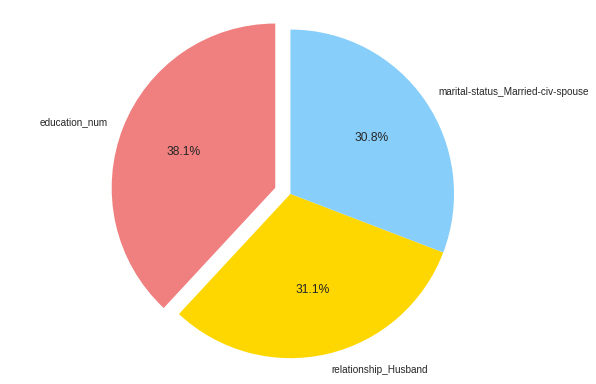

In [98]:
labels = [att for att in top_10_predicted_1['predicted_income'].index]

#labels = ['Cookies', 'Jellybean', 'Milkshake', 'Cheesecake']
sizes = [top_10_predicted_1['predicted_income'][i]*100/3 for i in range(3)]
#colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
explode = (0.1, 0, 0)  
colors = ['lightcoral', 'gold', 'lightskyblue']
#fig1, ax1 = plt.subplots()
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.tight_layout()
plt.savefig('corr3_a1.png', dpi= 500 )
plt.show()

### Now, make a version of this data, but with the attributes called “sex Female” and “sex Male” removed. Train a classifier on this data, exactly as in the previous section, but with the goal of predicting A instead of Y .

In [99]:
df_without_male_female = df.drop(['sex_Male', 'sex_Female'], axis=1)
df_test_without_male_female = df_test.drop(['sex_Male', 'sex_Female'], axis=1)
#get the training data

X_train_a = df_without_male_female  #contents only attributes in x
A_train = df_a

##loading test data
npz_test = np.load('adult/adult_test.npz')
df_test = pd.DataFrame(list(npz_test['x']))
df_test.columns = headers[0:len(headers)-1]

X_test_a = df_test_without_male_female 
A_test =  pd.DataFrame(list(npz_test['a']))
A_test.columns = ['sexe']


X_train_a = np.array(X_train_a)
A_train = np.array(A_train)
A_train = A_train.flatten()

X_test_a = np.array(X_test_a)
A_test = np.array(A_test)
A_test = A_test.flatten()

train_ind_a = np.random.choice(X_train_a.shape[0], 3*X_train_a.shape[0]//4, replace=False) ## choose indexes for train and validation set
#train_ind

#splitting the train data into train and val usin tain_ind_a
X_train_a, A_train = X_train_a[train_ind_a], A_train[train_ind_a]
X_val_a= df_without_male_female.drop(train_ind_a, axis=0)
A_val = df_a.drop(train_ind_a)
X_val_a = np.array(X_val_a)
A_val = np.array(A_val)
A_val = A_val.flatten()


##scaling the data using MinMaxScaler

# X_train_a = scaling_data(X_train_a)
# X_val_a = scaling_data(X_val_a)
# X_test_a = scaling_data(X_test_a)

In [100]:
model2 = build_model(X_train_a, A_train, X_val_a, A_val)

Train on 24420 samples, validate on 8141 samples
Epoch 1/300
24420/24420 [==============================] - 1s 48us/step - loss: 1.5188 - acc: 0.7503 - val_loss: 1.5212 - val_acc: 0.7618
Epoch 2/300
24420/24420 [==============================] - 1s 38us/step - loss: 1.5109 - acc: 0.7743 - val_loss: 1.4773 - val_acc: 0.7705
Epoch 3/300
24420/24420 [==============================] - 1s 34us/step - loss: 1.5071 - acc: 0.7743 - val_loss: 1.4548 - val_acc: 0.7826
Epoch 4/300
24420/24420 [==============================] - 1s 35us/step - loss: 1.4979 - acc: 0.7794 - val_loss: 1.4931 - val_acc: 0.7680
Epoch 5/300
24420/24420 [==============================] - 1s 35us/step - loss: 1.4978 - acc: 0.7814 - val_loss: 1.4539 - val_acc: 0.7821
Epoch 6/300
24420/24420 [==============================] - 1s 37us/step - loss: 1.4942 - acc: 0.7828 - val_loss: 1.4652 - val_acc: 0.7725
Epoch 7/300
24420/24420 [==============================] - 1s 37us/step - loss: 1.4934 - acc: 0.7815 - val_loss: 1.4572 - v

### Report accuracy and reweighted accuracy on the test set of your trained classifier.

In [101]:
score = evaluate_model(model2, X_test_a, A_test)
print('Test accuracy:', score)

Test accuracy: 0.7383453105285459


In [102]:
#A_hat=model3.predict(X_test_a)
A_hat = predict(model2, X_test_a)

print('reweighted accuracy', reweighted_accuracy(A_hat.flatten(), A_test, A_test))

reweighted accuracy 0.7421068415136144


### Removing 10 most correlated features with A

In [103]:
top_attributes = [att for att in top_10_corr_a['sexe'].index]
dfa_without_10 = df.drop(top_attributes, axis=1)
X_train = df_without_10
X_test = df_test.drop(top_attributes, axis=1)


In [104]:
X_train = np.array(X_train)
X_test = np.array(X_test)
#len(X_train)
A_train = df_a
A_train = np.array(A_train)
A_train = A_train.flatten()

train_ind = np.random.choice(X_train.shape[0], 3*X_train.shape[0]//4, replace=False) ## choose indexes for train and validation set
#A_train[train_ind]
#train_ind = np.random.choice(X_train.shape[0], 3*X_train.shape[0]//4, replace=False)
X_train, A_train = X_train[train_ind], A_train[train_ind]
X_val= dfa_without_10.drop(train_ind, axis=0)
A_val = df_a.drop(train_ind)
X_val= np.array(X_val)
A_val = np.array(A_val)
A_val = A_val.flatten()


##scaling the data using MinMaxScaler

# X_train= scaling_data(X_train)


# X_val = scaling_data(X_val)

# X_test = scaling_data(X_test)



In [105]:
model3 = build_model(X_train, A_train, X_val, A_val)

Train on 24420 samples, validate on 8141 samples
Epoch 1/300
24420/24420 [==============================] - 1s 50us/step - loss: 0.5384 - acc: 0.8087 - val_loss: 3.0221 - val_acc: 0.3985
Epoch 2/300
24420/24420 [==============================] - 1s 36us/step - loss: 0.5001 - acc: 0.8258 - val_loss: 5.5114 - val_acc: 0.3974
Epoch 3/300
24420/24420 [==============================] - 1s 36us/step - loss: 0.4916 - acc: 0.8301 - val_loss: 5.0116 - val_acc: 0.3985
Epoch 4/300
24420/24420 [==============================] - 1s 36us/step - loss: 0.4847 - acc: 0.8371 - val_loss: 7.2809 - val_acc: 0.3976
Epoch 5/300
24420/24420 [==============================] - 1s 36us/step - loss: 0.4798 - acc: 0.8387 - val_loss: 5.6933 - val_acc: 0.3987
Epoch 6/300
24420/24420 [==============================] - 1s 36us/step - loss: 0.4720 - acc: 0.8425 - val_loss: 6.5605 - val_acc: 0.4004
Epoch 7/300
24420/24420 [==============================] - 1s 36us/step - loss: 0.4661 - acc: 0.8455 - val_loss: 7.9929 - v

In [106]:
score = evaluate_model(model3, X_test, A_test)
print('Test accuracy:', score)

#A_hat=model3.predict(X_test_a)
A_hat = predict(model3, X_test)

print('reweighted accuracy', reweighted_accuracy(A_hat.flatten(), A_test, A_test))

Test accuracy: 0.3843744241717582
reweighted accuracy 0.5235692533945644


# Representation Learning

###  Data Pre-processing using Gaussian distribution:

In [107]:
def normalize_data(data, a):
    data1 = data
    n_a0 = np.where(a==0)[0]
    n_a1 = np.where(a==1)[0]
    for col_name in data1.columns:
        mean_0 = np.mean(data1[col_name][n_a0])
        std_0 = np.std(data1[col_name][n_a0])
        if std_0 < 1e-4:   #to avoid divide by 0
            std_0 = 1
        
        data1[col_name][n_a0] = (data1[col_name][n_a0] - mean_0)/std_0
       
            
        mean_1 = np.mean(data1[col_name][np.where(a==1)[0]])
        std_1 = np.std(data1[col_name][np.where(a==1)[0]])
        if np.isnan(mean_1):
            mean_1=0
        if std_1 < 1e-4:
            std_1 = 1
        data1[col_name][n_a1] = (data1[col_name][n_a1] - mean_1)/std_1
        
    return data1

In [108]:
df_normalize = normalize_data(df, df_a)
normalized_X_train = df_normalize
normalized_X_test = normalize_data(df_test, a_test)

### classifier g to predict Y from this pre-processed dataset

In [110]:
normalized_X_train = np.array(normalized_X_train)
Y_train = df_y
Y_train = np.array(Y_train)
Y_train = Y_train.flatten()


Y_test = pd.DataFrame(list(npz_test['y']))

normalized_X_test = np.array(normalized_X_test)
Y_test = np.array(Y_test)
Y_test = Y_test.flatten()

a_test =  pd.DataFrame(list(npz_test['a']))
a_test.columns = ['sexe']

train_ind = np.random.choice(normalized_X_train.shape[0], 3*X_train.shape[0]//4, replace=False) ## choose indexes for train and validation set

normalized_X_train, Y_train = normalized_X_train[train_ind], Y_train[train_ind]
normalized_X_val= df_normalize.drop(train_ind, axis=0)
Y_val = df_y.drop(train_ind)
normalized_X_val = np.array(normalized_X_val)
Y_val = np.array(Y_val)
Y_val = Y_val.flatten()

In [111]:
model4 = build_model(normalized_X_train, Y_train, normalized_X_val, Y_val)

Train on 18315 samples, validate on 14246 samples
Epoch 1/300
18315/18315 [==============================] - 1s 65us/step - loss: 0.3689 - acc: 0.8351 - val_loss: 0.3347 - val_acc: 0.8484
Epoch 2/300
18315/18315 [==============================] - 1s 42us/step - loss: 0.3260 - acc: 0.8503 - val_loss: 0.3251 - val_acc: 0.8522
Epoch 3/300
18315/18315 [==============================] - 1s 43us/step - loss: 0.3101 - acc: 0.8561 - val_loss: 0.3240 - val_acc: 0.8503
Epoch 4/300
18315/18315 [==============================] - 1s 42us/step - loss: 0.3026 - acc: 0.8584 - val_loss: 0.3269 - val_acc: 0.8536
Epoch 5/300
18315/18315 [==============================] - 1s 42us/step - loss: 0.2959 - acc: 0.8622 - val_loss: 0.3306 - val_acc: 0.8522
Epoch 6/300
18315/18315 [==============================] - 1s 42us/step - loss: 0.2877 - acc: 0.8645 - val_loss: 0.3256 - val_acc: 0.8529
Epoch 7/300
18315/18315 [==============================] - 1s 42us/step - loss: 0.2807 - acc: 0.8670 - val_loss: 0.3339 - 

In [112]:
score = evaluate_model(model4, normalized_X_test, Y_test)
print('Test accuracy:', score)
y_hat = predict(model4, normalized_X_test)
print('delta DP', compute_delta_DP(y_hat, a_test))

Test accuracy: 0.8215097352669241
delta DP 0.15690801375049557


### classifier h to predict A from this pre-processed dataset

In [113]:
df_normalize_without_male_female  = normalize_data(df_without_male_female, df_a)
normalized_X_test_without_male_female = normalize_data(df_test_without_male_female, a_test)

In [114]:
normalized_X_train_without_male_female = df_normalize_without_male_female  #contents only attributes in x
A_train = df_a

##loading test data
#normalized_X_test_without_male_female = normalized_X_test_without_male_female  

A_test =  pd.DataFrame(list(npz_test['a']))
A_test.columns = ['sexe']


normalized_X_train_without_male_female = np.array(normalized_X_train_without_male_female)
A_train = np.array(A_train)
A_train = A_train.flatten()

normalized_X_test_without_male_female= np.array(normalized_X_test_without_male_female)
A_test = np.array(A_test)
# A_test = A_test.flatten()

train_ind_a = np.random.choice(normalized_X_train_without_male_female.shape[0], 3*normalized_X_train_without_male_female.shape[0]//4, replace=False) ## choose indexes for train and validation set
#train_ind

#splitting the train data into train and val usin tain_ind_a
normalized_X_train_without_male_female, A_train = normalized_X_train_without_male_female[train_ind_a], A_train[train_ind_a]
X_val_normalized_a= df_without_male_female.drop(train_ind_a, axis=0)
A_val = df_a.drop(train_ind_a)
X_val_normalized_a = np.array(X_val_normalized_a)
A_val = np.array(A_val)
A_val = A_val.flatten()



In [115]:
model5 = build_model(normalized_X_train_without_male_female, A_train, X_val_normalized_a, A_val)

Train on 24420 samples, validate on 8141 samples
Epoch 1/300
24420/24420 [==============================] - 2s 68us/step - loss: 0.1553 - acc: 0.9412 - val_loss: 0.0335 - val_acc: 0.9937
Epoch 2/300
24420/24420 [==============================] - 1s 51us/step - loss: 0.0134 - acc: 0.9970 - val_loss: 0.0174 - val_acc: 0.9957
Epoch 3/300
24420/24420 [==============================] - 1s 37us/step - loss: 0.0092 - acc: 0.9982 - val_loss: 0.0065 - val_acc: 0.9980
Epoch 4/300
24420/24420 [==============================] - 1s 37us/step - loss: 0.0039 - acc: 0.9992 - val_loss: 0.0113 - val_acc: 0.9975
Epoch 5/300
24420/24420 [==============================] - 1s 38us/step - loss: 0.0054 - acc: 0.9990 - val_loss: 0.0043 - val_acc: 0.9988
Epoch 6/300
24420/24420 [==============================] - 1s 39us/step - loss: 0.0046 - acc: 0.9992 - val_loss: 0.0050 - val_acc: 0.9983
Epoch 7/300
24420/24420 [==============================] - 1s 38us/step - loss: 0.0046 - acc: 0.9991 - val_loss: 0.0085 - v

In [116]:
score = evaluate_model(model5, normalized_X_test_without_male_female, A_test)
print('Test accuracy:', score)

Test accuracy: 0.999324365825195


In [117]:
A_hat_normalised = predict(model5, normalized_X_test_without_male_female)
reweighted_accuracy(A_hat_normalised, A_test, A_test)

0.9994473609382787

### Now, let’s try a neural network solution. Train a neural network with at least one hidden layer as your binary classifier. Use a cross-entropy loss, and include an MMD regularizer on the final hidden layer of the network

In [118]:
from mmd import MMD_torch
import torch

In [123]:
def build_model_with_regularizer(train_data, train_target, val_data, val_target,regularizer, batch_size=32, epochs=20, verbose=1):
    # Build neural network
    model1 = Sequential()
    model1.add(Dense(256, activation='relu', input_dim=train_data.shape[1]))
    #model.add(Dropout(0.1))
    model1.add(Dense(128, activation='relu', kernel_regularizer=regularizer))
    #model.add(Dropout(0.1))
    model1.add(Dense(1, activation='sigmoid'))

    # Compile model
    model1.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])

    # Train model
    model1.fit(train_data, train_target,
              batch_size=batch_size,
              epochs=epochs,
              verbose=verbose,
              validation_data=(val_data, val_target))
    return model1

In [124]:
A = df_a
A = np.array(A)[:5000]
A = torch.tensor(A)

Z = df
Z = np.array(Z)



Z = torch.tensor(Z)[:5000]
#from keras import backend as K
a = MMD_torch(Z, A).item()

In [125]:
#redefine the keras l1 regularizer

alphas = [1, 0.1, 0.01, 0.001, 0.0001]
accuracies = []
delta_DPs = []
accuracies_A = []
reweighted_acc = []
for alpha in alphas:
    print('model for alpha == ', alpha)
    def l1_reg(alpha):
        return alpha*a
    print('===================================classifier g=================================================')
    # Build neural network
    model6 = build_model_with_regularizer(normalized_X_train, Y_train, normalized_X_val, Y_val, l1_reg, batch_size=16, epochs= 20, verbose=0,)
    score = evaluate_model(model6, normalized_X_test, Y_test)
    accuracies.append(score)
    print('Test accuracy for Y:', score)
    y_hat_after_mmd = predict(model6, normalized_X_test)
    delta_DPs.append(compute_delta_DP(y_hat_after_mmd.flatten(), Y_test))
    print('deltaDP for Y', compute_delta_DP(y_hat_after_mmd.flatten(), Y_test))
    print('=='*50)
    
    print('===================================classifier h=================================================')
    model7 = build_model_with_regularizer(normalized_X_train_without_male_female, A_train, X_val_normalized_a, A_val, l1_reg, batch_size=16, epochs= 20, verbose=0)
    score = evaluate_model(model7, normalized_X_test_without_male_female, A_test)
    accuracies_A.append(score)
    print('Test accuracy for A:', score)
    A_hat_mmd = predict(model7, normalized_X_test_without_male_female)
    reweighted_acc.append(reweighted_accuracy(A_hat_mmd, A_test, A_test))
    print('reweighted accuracy for A', reweighted_accuracy(A_hat_mmd, A_test, A_test))
    print('=='*50)

model for alpha ==  1
===================================classifier g=================================================
Test accuracy for Y: 0.8345310484870236
deltaDP for Y 0.4780466538323777
===================================classifier h=================================================
Test accuracy for A: 0.999324365825195
reweighted accuracy for A 0.9992625873801596
model for alpha ==  0.1
===================================classifier g=================================================
Test accuracy for Y: 0.8267919661210756
deltaDP for Y 0.5228691849724653
===================================classifier h=================================================
Test accuracy for A: 0.9992629445365764
reweighted accuracy for A 0.9993089336435654
model for alpha ==  0.01
===================================classifier g=================================================
Test accuracy for Y: 0.8300472943592874
deltaDP for Y 0.493727194202364
===================================classifier h==========

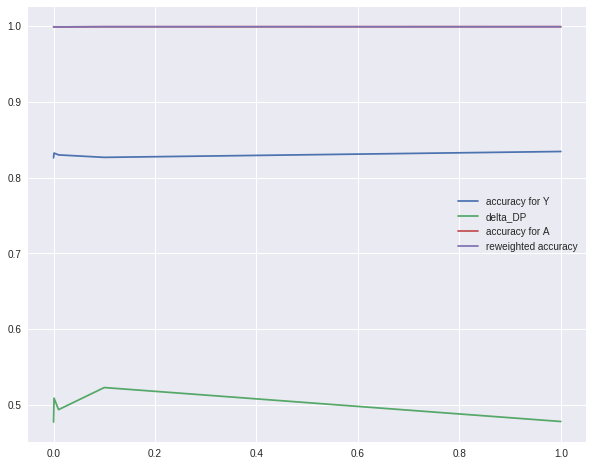

In [127]:
plt.figure(figsize=(10, 8))
plt.plot(alphas,accuracies, label='accuracy for Y')
plt.plot(alphas,delta_DPs, label='delta_DP')
plt.plot(alphas,accuracies_A, label='accuracy for A')
plt.plot(alphas,reweighted_acc, label='reweighted accuracy')
plt.legend()
plt.savefig('mmd.png', dpi=500)
plt.show()